# Experiment: Concept Drift Detection

In this experiment we use float to compare the effect of different active concept drift detection techniques.

In [1]:
# Optional: Rebase the file path.
# Note that you may also provide explicit file paths and avoid this step.
import os
os.chdir(os.getcwd()[:-18])

In [2]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import zero_one_loss
from skmultiflow.drift_detection import ADWIN, PageHinkley
from skmultiflow.trees import HoeffdingTreeClassifier

# Import float modules
from float.data import DataLoader
from float.change_detection import ERICS
from float.change_detection.tornado import EDDM
from float.change_detection.evaluation import ChangeDetectionEvaluator
from float.change_detection.evaluation.measures import mean_time_ratio, missed_detection_rate
from float.change_detection.skmultiflow import SkmultiflowChangeDetector
from float.pipeline import PrequentialPipeline
from float.prediction.evaluation import PredictionEvaluator
from float.prediction.skmultiflow import SkmultiflowClassifier
import float.visualization as fvis

In [3]:
# - Create a data loader object -
# We load the TüEyeQ data set, which contains natural concept drift.
data_loader = DataLoader(path='float/data/datasets/iq.csv',  # This path might have to be adjusted!
                         target_col=-1)

# - Specify known concept drifts -
# The drifts in TüEyeQ correspond to three switches between task blocks.
known_drifts = [4707, 9396, 13570]

# - Create the predictor objects. -
# We use the default parameters of the skmultiflow implementation of the Hoeffding Tree.
# Note that we tell the classifers to reset after a drift was detected.
predictors = [SkmultiflowClassifier(model=HoeffdingTreeClassifier(), 
                                  classes=data_loader.stream.target_values, 
                                  reset_after_drift=True),
              SkmultiflowClassifier(model=HoeffdingTreeClassifier(), 
                                  classes=data_loader.stream.target_values, 
                                  reset_after_drift=True),
              SkmultiflowClassifier(model=HoeffdingTreeClassifier(), 
                                  classes=data_loader.stream.target_values, 
                                  reset_after_drift=True),
              SkmultiflowClassifier(model=HoeffdingTreeClassifier(), 
                                  classes=data_loader.stream.target_values, 
                                  reset_after_drift=True)]  # We use the same predictor for each concept drift detection method

# - Create evaluator objects corresponding to the classifiers. -
# These evaluators will compute and store the performance measures when running the pipeline.
# For illustration, we just compute the zero_one_loss.
pred_evaluators = [PredictionEvaluator(measure_funcs=[zero_one_loss]),
                   PredictionEvaluator(measure_funcs=[zero_one_loss]),
                   PredictionEvaluator(measure_funcs=[zero_one_loss]),
                   PredictionEvaluator(measure_funcs=[zero_one_loss])]

# - Create change detector objects for each concept drift detection method -
# We can freely combine drift detectors from scikit-multiflow (e.g. ADWIN), Tornado (e.g. EDDM)..
# ..and pre-build float models (e.g. ERICS).
# We reset ADWIN, PageHinkley and EDDM after detecting a drift, which is not required for ERICS
change_detectors = [SkmultiflowChangeDetector(ADWIN(), reset_after_drift=True),
                    SkmultiflowChangeDetector(PageHinkley(), reset_after_drift=True),
                    EDDM(reset_after_drift=True),
                    ERICS(n_param=data_loader.stream.n_features)]


# - Create evaluator objects corresponding to each change detector. -
# We compute the missed detection rate and the mean time ratio measure, which is an aggregation of different change detection evaluation measures.
# The mean time ratio requires the input parameters (known) drifts and the following parameters 
# - batch_size, the batch size used for training.
# - n_total, the total number of observations
# - n_init_tolerance, the initial tolerance (no. of observations), during which drift detections are not considered.
# - n_delay, which defines in which period (no. of observations) after a known drift we count detections as true positive.
#   Note that we provide a list of n_delays, the reported mean time ratios will be averaged results for these different tolerances.
cd_evaluators = [ChangeDetectionEvaluator(measure_funcs=[mean_time_ratio, missed_detection_rate],
                                          known_drifts=known_drifts,
                                          batch_size=10,
                                          n_total=data_loader.stream.n_samples,
                                          n_init_tolerance=25,
                                          n_delay=list(range(100, 1000))),
                 ChangeDetectionEvaluator(measure_funcs=[mean_time_ratio, missed_detection_rate],
                                          known_drifts=known_drifts,
                                          batch_size=10,
                                          n_total=data_loader.stream.n_samples,
                                          n_init_tolerance=25,
                                          n_delay=list(range(100, 1000))),
                 ChangeDetectionEvaluator(measure_funcs=[mean_time_ratio, missed_detection_rate],
                                          known_drifts=known_drifts,
                                          batch_size=10,
                                          n_total=data_loader.stream.n_samples,
                                          n_init_tolerance=25,
                                          n_delay=list(range(100, 1000))),
                 ChangeDetectionEvaluator(measure_funcs=[mean_time_ratio, missed_detection_rate],
                                         known_drifts=known_drifts,
                                         batch_size=10,
                                         n_total=data_loader.stream.n_samples,
                                         n_init_tolerance=25,
                                         n_delay=list(range(100, 1000)))]  # We evaluate each change detector w.r.t the same measures.

# - Run the Experiments for each change detector -
for predictor, pred_eval, detector, drift_eval in zip(predictors, pred_evaluators, change_detectors, cd_evaluators):    
    # - Create a prequential pipeline -
    # We use a batch-incremental scheme, processing the data in batches of size 10.
    # Moreover, we set a random state for reproducibility.
    pipeline = PrequentialPipeline(data_loader=data_loader,
                                   change_detector=detector,
                                   change_detection_evaluator=drift_eval,
                                   predictor=predictor,
                                   prediction_evaluator=pred_eval,
                                   batch_size=10,
                                   n_max=data_loader.stream.n_samples,  # We use all observations
                                   known_drifts=known_drifts,
                                   random_state=0)
    
    pipeline.run()

Pretrain the predictor with 100 observation(s).
[====================] 100%, No. of detected drifts: 9, Last detected drift at t=1471.
################################## SUMMARY ##################################
Evaluation has finished after 24.587559700012207s
Data Set float/data/datasets/iq.csv
The pipeline has processed 15762 instances in total, using batches of size 10.
----------------------
Concept Drift Detection:
| Model   |   Avg. Comp. Time | Detected Global Drifts         |   Avg. mean_time_ratio |   Avg. missed_detection_rate |
|---------|-------------------|--------------------------------|------------------------|------------------------------|
| ADWIN   |       0.000456316 | [223, 447, 639, 735, 863, ...] |                      0 |                            1 |
----------------------
Prediction:
| Model                   |   Avg. Test Comp. Time |   Avg. Train Comp. Time |   Avg. zero_one_loss |
|-------------------------|------------------------|----------------------

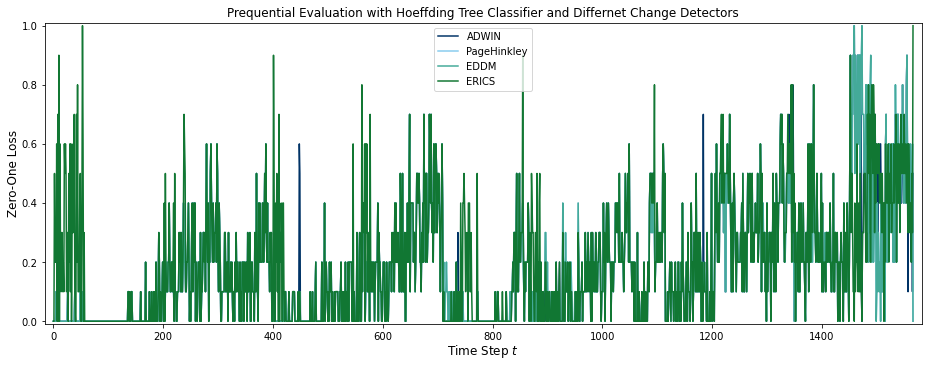

In [7]:
# - Illustrate results - 
# The float visualizer contains standard plot types like line, scatter or bar, but also provides special plots..
# ..for concept drift detection and feature selection. 
# We illustrate the visualization of concept drift detection experiments in the following.

# - Plot the loss of the classifier for different drift detection models -
ax = fvis.plot(measures=[evaluator.result['zero_one_loss']['measures'] for evaluator in pred_evaluators],
               legend_labels=['ADWIN', 'PageHinkley', 'EDDM', 'ERICS'],
               fig_size=(13, 5),
               y_label='Zero-One Loss')

ax.set_title('Prequential Evaluation with Hoeffding Tree Classifier and Differnet Change Detectors')  # The returned matplotlib object can be altered and further customized.

#plt.savefig('float/experiments/zero_one_loss_drift_detection.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()

In [5]:
# - Compare the Mean Time Ratio of the change detection methods -
# The mean time ratio is stored in the result dictionary of the change detection evaluator object and can easily be accessed,...
# ..e.g. to create a table.
table = pd.DataFrame(0, index=['Mean Time Ratio', 'Missed Detection Rate'], columns=['ADWIN', 'EDDM', 'ERICS'])

for drift_eval, name in zip(cd_evaluators, ['ADWIN', 'PageHinkely', 'EDDM', 'ERICS']):
    table.loc['Mean Time Ratio', name] = '{:0.2f}'.format(drift_eval.result['mean_time_ratio']['mean']) + ' ' + u"\u00B1" + ' ' + '{:0.2f}'.format(drift_eval.result['mean_time_ratio']['var'])
    table.loc['Missed Detection Rate', name] = '{:0.2f}'.format(drift_eval.result['missed_detection_rate']['mean']) + ' ' + u"\u00B1" + ' ' + '{:0.2f}'.format(drift_eval.result['missed_detection_rate']['var'])

table

,ADWIN,EDDM,ERICS,PageHinkely
Mean Time Ratio,0.00 ± 0.00,0.00 ± 0.00,0.03 ± 0.00,0.00 ± 0.00
Missed Detection Rate,1.00 ± 0.00,1.00 ± 0.00,0.81 ± 0.04,1.00 ± 0.00


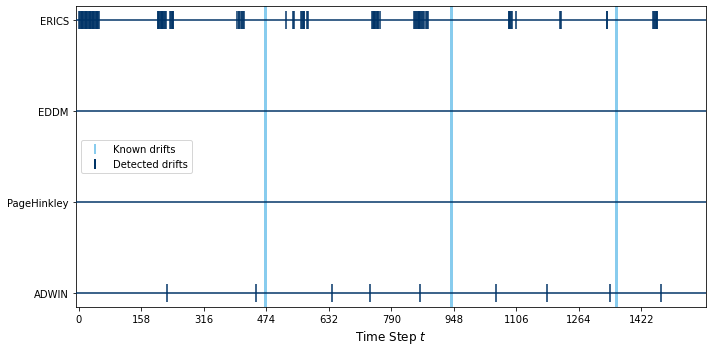

In [6]:
# - Illustrate the detected drifts -
# Float provides a special scatter plot that allows for an intuitive comparison of drift detection methods over time.
fvis.concept_drift_detection_scatter(detected_drifts=[detector.drifts for detector in change_detectors],
                                     model_names=['ADWIN', 'PageHinkley', 'EDDM', 'ERICS'],
                                     n_samples=data_loader.stream.n_samples,
                                     known_drifts=known_drifts,
                                     batch_size=10,
                                     n_pretrain=0)  # We did not pre-train the classifier

ax.set_title('Comparison of Detected Drifts Over Time')

#plt.savefig('float/experiments/detected_drifts.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()